
# Watershed Dynamics Model 

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:300px;padding:20px">   


<br />
This Jupyter Notebook runs the Landlab LandslideProbability component on a synthetic 
Landlab grid using four recharge options as described in the paper: <br />
#### Strauch et al. 2018. A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6, 1-26. <br /> 
This notebook performs the following functions:<br >
* Import libraries and set HydroShare variables<br />
* Create a grid and data fields used to calculate landslide probability<br />
* Specify Recharge Distributions to compare four options<br /> 
* Run LandslideProbability function from Landlab landslide component<br /> 
* Compare the sensitivity based on four recharge options<br /> 



## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

In [1]:
#import Python utilities for calculating and plotting
import numpy as np
import matplotlib.pyplot as plt

#import Landlab
from landlab import RasterModelGrid
#from landlab.components import landslides
#from landlab.components.landslides import LandslideProbability
from landlab.plot import imshow_grid
from landlab.io import read_esri_ascii



In [62]:
#!/usr/env/python
"""Landlab component that simulates landslide probability of failure as well as
mean relative wetness and probability of saturation.

Relative wetness and factor-of-safety are based on the infinite slope
stability model driven by topographic and soils inputs and recharge provided
by user as inputs to the component. For each node, component simulates mean
relative wetness as well as the probability of saturation based on Monte Carlo
simulation of relative wetness where the probability is the number of
iterations with relative wetness >= 1.0 divided by the number of iterations.
Probability of failure for each node is also simulated in the Monte Carlo
simulation as the number of iterations with factor-of-safety <= 1.0
divided by the number of iterations.

.. codeauthor:: R.Strauch, C.Bandaragoda, E.Istanbulluoglu, & S.S.Nudurupati

University of Washington

Ref 1: Strauch et. al. 2017, 'A hydro-climatological approach to predicting
regional landslide probability using Landlab, Earth Surface Dynamics, In prep.

Ref 2: 'The Landlab LandslideProbability Component User Manual' @
https://github.com/RondaStrauch/pub_strauch_etal_esurf/blob/master/LandslideComponentUsersManual.pdf

Created on Thu Aug 20, 2015
Last feature edits June 7, 2017
Landlab v2 and PEP8 updates by mcflugen and kbarnhart 2018-2019
Component Changes: April 28, 2020
Add depth to water table as an optional hydrology input (alternative to recharge)

"""

import copy
import pandas as pd
import numpy as np
import scipy.constants
from scipy import interpolate
from statsmodels.distributions.empirical_distribution import ECDF

from landlab import Component

class LandslideProbability(Component):
    """Landslide probability component using the infinite slope stability
    model.

    Landlab component designed to calculate probability of failure at
    each grid node based on the infinite slope stability model
    stability index (Factor of Safety).

    The driving force for failure is provided by the user in the form of
    groundwater recharge OR depth to groundwater. Four options for providing 
    recharge plus four options of depth to groundwater are supported.
    The model uses topographic and soil characteristics provided as input
    by the user.

    The main method of the LandslideProbability class is
    `calculate_landslide_probability()`, which calculates the mean soil
    relative wetness, mean water table depth, mean recharge, probability of soil saturation, 
    and probability of failure at each node based on a Monte Carlo simulation.   

    **Usage:**

    Option 1 - Uniform recharge

    .. code-block:: python

        LandslideProbability(grid,
                             number_of_iterations=250,
                             groundwater__recharge_distribution='uniform',
                             groundwater__recharge_min_value=5.,
                             groundwater__recharge_max_value=120.)

    Option 2 - Lognormal recharge

    .. code-block:: python

        LandslideProbability(grid,
                             number_of_iterations=250,
                             groundwater__recharge_distribution='lognormal',
                             groundwater__recharge_mean=30.,
                             groundwater__recharge_standard_deviation=0.25)

    Option 3 - Lognormal_spatial recharge

    .. code-block:: python

        LandslideProbability(grid,
                             number_of_iterations=250,
                             groundwater__recharge_distribution='lognormal_spatial',
                             groundwater__recharge_mean=np.random.randint(20, 120, grid_size),
                             groundwater__recharge_standard_deviation=np.random.rand(grid_size))

    Option 4 - Data_driven_spatial recharge

    .. code-block:: python

        LandslideProbability(grid,
                             number_of_iterations=250,
                             groundwater__recharge_distribution='data_driven_spatial',
                             groundwater__recharge_HSD_inputs=[HSD_dict,
                                                               HSD_id_dict,
                                                               fract_dict])
    Option 5 - Uniform depth to groundwater

    .. code-block:: python
    
        LandslideProbability(grid, 
                             number_of_iterations=250,
                             groundwater__depth_distribution='uniform', 
                             groundwater__depth_min_value=0.01, 
                             groundwater__depth_max_value=1.5)
                             
    Option 6 - Lognormal depth to groundwater 
    
    .. code-block:: python
        
        LandslideProbability(grid, number_of_iterations=250,
                             groundwater__depth_distribution='lognormal', 
                             groundwater__depth_mean=0.5.,
                             groundwater__depth_standard_deviation=0.1)
                             
    Option 7 - Lognormal_spatial depth to groundwater 
    
    .. code-block:: python
    
        LandslideProbability(grid, number_of_iterations=250,
                             groundwater__depth_distribution='lognormal_spatial', 
                             groundwater__depth_mean=np.random.randint(0, 2, grid_size),
                             groundwater__depth_standard_deviation=np.random.rand(grid_size))   
                             
    Option 8 - Data_driven_spatial depth to groundwater
    
    .. code-block:: python
    
        LandslideProbability(grid, number_of_iterations=250, 
                             groundwater__depth_distribution='data_driven_spatial', 
                             groundwater__depth_HSD_inputs={HSD_dict})

    Examples
    --------
    >>> from landlab import RasterModelGrid
    >>> from landlab.components.landslides import LandslideProbability
    >>> import numpy as np

    Create a grid on which to calculate landslide probability.

    >>> grid = RasterModelGrid((5, 4))

    Check the number of core nodes.

    >>> grid.number_of_core_nodes
    6

    The grid will need some input data. To check the names of the fields
    that provide the input to this component, use the *input_var_names*
    class property.

    >>> sorted(LandslideProbability.input_var_names)  # doctest: +NORMALIZE_WHITESPACE
    ['soil__density',
     'soil__internal_friction_angle',
     'soil__maximum_total_cohesion',
     'soil__minimum_total_cohesion',
     'soil__mode_total_cohesion',
     'soil__saturated_hydraulic_conductivity',
     'soil__thickness',
     'soil__transmissivity',
     'topographic__slope',
     'topographic__specific_contributing_area']

    Check the units for the fields.

    >>> LandslideProbability.var_units('topographic__specific_contributing_area')
    'm'

    Create an input field.

    >>> grid.at_node['topographic__slope'] = np.random.rand(grid.number_of_nodes)

    If you are not sure about one of the input or output variables, you can
    get help for specific variables.

    >>> LandslideProbability.var_help('soil__transmissivity')  # doctest: +NORMALIZE_WHITESPACE
    name: soil__transmissivity
    description:
      mode rate of water transmitted through a unit width of saturated
      soil - either provided or calculated with Ksat and soil depth
    units: m2/day
    unit agnostic: False
    at: node
    intent: in

    Additional required fields for component.

    >>> scatter_dat = np.random.randint(1, 10, grid.number_of_nodes)
    >>> grid.at_node['topographic__specific_contributing_area'] = np.sort(
    ...      np.random.randint(30, 900, grid.number_of_nodes).astype(float))
    >>> grid.at_node['soil__transmissivity'] = np.sort(
    ...      np.random.randint(5, 20, grid.number_of_nodes).astype(float), -1)
    >>> grid.at_node['soil__saturated_hydraulic_conductivity'] = np.sort(
    ...      np.random.randint(2, 10, grid.number_of_nodes).astype(float), -1)
    >>> grid.at_node['soil__mode_total_cohesion'] = np.sort(
    ...      np.random.randint(30, 900, grid.number_of_nodes).astype(float))
    >>> grid.at_node['soil__minimum_total_cohesion'] = (
    ...      grid.at_node['soil__mode_total_cohesion'] - scatter_dat)
    >>> grid.at_node['soil__maximum_total_cohesion'] = (
    ...      grid.at_node['soil__mode_total_cohesion'] + scatter_dat)
    >>> grid.at_node['soil__internal_friction_angle'] = np.sort(
    ...      np.random.randint(26, 40, grid.number_of_nodes).astype(float))
    >>> grid.at_node['soil__thickness'] = np.sort(
    ...      np.random.randint(1, 10, grid.number_of_nodes).astype(float))
    >>> grid.at_node['soil__density'] = (2000. * np.ones(grid.number_of_nodes))

    Instantiate the 'LandslideProbability' component to work on this grid,
    and run it.

    >>> ls_prob = LandslideProbability(grid)
    >>> np.allclose(grid.at_node['landslide__probability_of_failure'], 0.)
    True

    Run the *calculate_landslide_probability* method to update output
    variables with grid

    >>> ls_prob.calculate_landslide_probability()

    Check the output variable names.

    >>> sorted(ls_prob.output_var_names) # doctest: +NORMALIZE_WHITESPACE
    ['landslide__probability_of_failure',
     'soil__mean_relative_wetness',
     'soil__mean_watertable_depth',
     'soil__probability_of_saturation']

    Check the output from the component, including array at one node.

    >>> np.allclose(grid.at_node['landslide__probability_of_failure'], 0.)
    False
    >>> core_nodes = ls_prob.grid.core_nodes

    References
    ----------
    **Required Software Citation(s) Specific to this Component**

    Strauch, R., Istanbulluoglu, E., Nudurupati, S., Bandaragoda, C.,
    Gasparini, N., Tucker, G. (2018). A hydroclimatological approach to
    predicting regional landslide probability using Landlab Earth Surface
    Dynamics  6(1), 49-75. https://dx.doi.org/10.5194/esurf-6-49-2018

    **Additional References**

    Publication Pending

    """

    # component name
    _name = "Landslide Probability"

    _unit_agnostic = False

    __version__ = "2.0"

    _cite_as = """
    @article{strauch2018hydroclimatological,
      author = {Strauch, Ronda and Istanbulluoglu, Erkan and Nudurupati,
      Sai Siddhartha and Bandaragoda, Christina and Gasparini, Nicole M and
      Tucker, Gregory E},
      title = {{A hydroclimatological approach to predicting regional landslide
      probability using Landlab}},
      issn = {2196-6311},
      doi = {10.5194/esurf-6-49-2018},
      pages = {49--75},
      number = {1},
      volume = {6},
      journal = {Earth Surface Dynamics},
      year = {2018}
    }
    """
    _info = {
        "landslide__probability_of_failure": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "None",
            "mapping": "node",
            "doc": "number of times FS is <=1 out of number of iterations user selected",
        },
        "soil__density": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "kg/m3",
            "mapping": "node",
            "doc": "wet bulk density of soil",
        },
        "soil__internal_friction_angle": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "degrees",
            "mapping": "node",
            "doc": "critical angle just before failure due to friction between particles",
        },
        "soil__maximum_total_cohesion": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "Pa or kg/m-s2",
            "mapping": "node",
            "doc": "maximum of combined root and soil cohesion at node",
        },
        "soil__mean_relative_wetness": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "None",
            "mapping": "node",
            "doc": "Indicator of soil wetness; relative depth perched water table within the soil layer",
        },
        "soil__mean_watertable_depth": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Mean depth to water table from surface to perched water table within the soil layer",
        },
        
        "soil__minimum_total_cohesion": {
            "dtype": float,
            "intent": "in",
            "optional": True,
            "units": "Pa or kg/m-s2",
            "mapping": "node",
            "doc": "minimum of combined root and soil cohesion at node",
        },
        "soil__mode_total_cohesion": {
            "dtype": float,
            "intent": "in",
            "optional": True,
            "units": "Pa or kg/m-s2",
            "mapping": "node",
            "doc": "mode of combined root and soil cohesion at node",
        },
        "soil__probability_of_saturation": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "None",
            "mapping": "node",
            "doc": "number of times relative wetness is >=1 out of number of iterations user selected",
        },
        "soil__saturated_hydraulic_conductivity": {
            "dtype": float,
            "intent": "in",
            "optional": True,
            "units": "m/day",
            "mapping": "node",
            "doc": "mode rate of water transmitted through soil. If transmissivity is NOT provided, the component calculates transmissivity using Ksat and soil depth",
        },
        "soil__thickness": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "soil depth to restrictive layer",
        },
        "soil__transmissivity": {
            "dtype": float,
            "intent": "in",
            "optional": True,
            "units": "m2/day",
            "mapping": "node",
            "doc": "mode rate of water transmitted through a unit width of saturated soil - either provided or calculated with Ksat and soil depth",
        },
        "topographic__slope": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "tan theta",
            "mapping": "node",
            "doc": "gradient of the ground surface",
        },
        "topographic__specific_contributing_area": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "specific contributing (upslope area/cell face ) that drains to node",
        },
    }

    def __init__(
        self,
        grid,
        number_of_iterations=250,
        g=scipy.constants.g,
        groundwater__recharge_distribution=None,
        groundwater__recharge_min_value=20.0,
        groundwater__recharge_max_value=120.0,
        groundwater__recharge_mean=None,
        groundwater__recharge_standard_deviation=None,
        groundwater__recharge_HSD_inputs=[],
        groundwater__depth_distribution=None,
        groundwater__depth_min_value=0.01,
        groundwater__depth_max_value=3.,
        groundwater__depth_mean=None,
        groundwater__depth_standard_deviation=None,
        groundwater__depth_HSD_inputs={},
        seed=0,
    ):
     
        """
        Parameters
        ----------
        grid: RasterModelGrid
            A raster grid.
        number_of_iterations: int, optional
            Number of iterations to run Monte Carlo simulation (default=250).
        groundwater__recharge_distribution: str, optional
            single word indicating recharge distribution, either 'uniform',
            'lognormal', 'lognormal_spatial,' or 'data_driven_spatial'.
            (default='uniform')
        groundwater__recharge_min_value: float, optional (mm/d)
            minimum groundwater recharge for 'uniform' (default=20.0)
        groundwater__recharge_max_value: float, optional (mm/d)
            maximum groundwater recharge for 'uniform' (default=120.0)
        groundwater__recharge_mean: float, optional (mm/d)
            mean groundwater recharge for 'lognormal'
            and 'lognormal_spatial' (default=None)
        groundwater__recharge_standard_deviation: float, optional (mm/d)
            standard deviation of groundwater recharge for 'lognormal'
            and 'lognormal_spatial' (default=None)
        groundwater__recharge_HSD_inputs: list, optional
            list of 3 dictionaries in order (default=[]) - HSD_dict
            {Hydrologic Source Domain (HSD) keys: recharge numpy array values},
            {node IDs keys: list of HSD_Id values}, HSD_fractions {node IDS
            keys: list of HSD fractions values} (none)
            Note: this input method is a very specific one, and to use this method,
            one has to refer Ref 1 & Ref 2 mentioned above, as this set of
            inputs require rigorous pre-processing of data.
        groundwater__depth_distribution: str, optional
            single word indicating depth to water table distribution, either 
            'uniform', 'lognormal', 'lognormal_spatial,' or 
            'data_driven_spatial'.
             (default=None)
        groundwater__depth_min_value: float, optional (m)
            minimum groundwater depth to water table for 'uniform' (default=0.01)
        groundwater__depth_max_value: float, optional (m)
            maximum groundwater depth for 'uniform' (default=2.)
        groundwater__depth_mean: float, optional (m) 
            mean groundwater depth to water table for 'lognormal'
            and 'lognormal_spatial' (default=None)
        groundwater__depth_standard_deviation: float, optional (m)
            standard deviation of groundwater depth to water table for 
            'lognormal' and 'lognormal_spatial' (default=None)
        groundwater__depth_HSD_inputs: dictionary, optional
            one dictionary (default={}) - HSD_dict
            {Hydrologic Source Domain (HSD) Grid equal size to Landlab 
            node ID keys: groundwater depth distribution numpy array values}
        g: float, optional (m/sec^2)
            acceleration due to gravity.
        seed: int, optional
            seed for random number generation. if seed is assigned any value
            other than the default value of zero, it will create different
            sequence. To create a certain sequence repetitively, use the same
            value as input for seed.
        """
        # Initialize seeded random number generation
        self._seed_generator(seed)

        super().__init__(grid)

        # Store parameters and do unit conversions
        self._n = int(number_of_iterations)
        self._g = g
        self._groundwater__recharge_distribution = groundwater__recharge_distribution
        self._groundwater__depth_distribution = groundwater__depth_distribution
            
        # Following code will deal with the input distribution and associated
        # parameters for recharge hydrologic forcing
        # Recharge Uniform distribution
        if self._groundwater__recharge_distribution == "uniform":
            self._recharge_min = groundwater__recharge_min_value
            self._recharge_max = groundwater__recharge_max_value
            self._Re = np.random.uniform(
                self._recharge_min, self._recharge_max, size=self._n
            )
            self._Re /= 1000.0  # Convert mm to m
        # Recharge Lognormal Distribution - Uniform in space
        elif self._groundwater__recharge_distribution == "lognormal":
            assert (
                groundwater__recharge_mean is not None
            ), "Input groundwater__recharge_mean and try again!"
            assert (
                groundwater__recharge_standard_deviation is not None
            ), "Input missing standard deviation of the distribution!"
            self._recharge_mean = groundwater__recharge_mean
            self._recharge_stdev = groundwater__recharge_standard_deviation
            self._mu_lognormal = np.log(
                (self._recharge_mean ** 2)
                / np.sqrt(self._recharge_stdev ** 2 + self._recharge_mean ** 2)
            )
            self._sigma_lognormal = np.sqrt(
                np.log((self._recharge_stdev ** 2) / (self._recharge_mean ** 2) + 1)
            )
            self._Re = np.random.lognormal(
                self._mu_lognormal, self._sigma_lognormal, self._n
            )
            self._Re /= 1000.0  # Convert mm to m
        # Recharge Lognormal Distribution - Variable in space
        elif self._groundwater__recharge_distribution == "lognormal_spatial":
            assert groundwater__recharge_mean.shape[0] == (
                self._grid.number_of_nodes
            ), "Input array should be of the length of grid.number_of_nodes!"
            assert groundwater__recharge_standard_deviation.shape[0] == (
                self._grid.number_of_nodes
            ), "Input array should be of the length of grid.number_of_nodes!"
            self._recharge_mean = groundwater__recharge_mean
            self._recharge_stdev = groundwater__recharge_standard_deviation
        # Recharge Custom HSD inputs - Hydrologic Source Domain -> Model Domain
        elif self._groundwater__recharge_distribution == "data_driven_spatial":
            self._HSD_dict = groundwater__recharge_HSD_inputs[0]
            self._HSD_id_dict = groundwater__recharge_HSD_inputs[1]
            self._fract_dict = groundwater__recharge_HSD_inputs[2]
            self._interpolate_HSD_dict()
  
        # Following code will deal with the input distribution and associated
        # parameters for depth to water table hydrologic forcing
        # Depth to water table - Uniform distribution
        if self._groundwater__depth_distribution == "uniform":
            self._depth_min = groundwater__depth_min_value
            self._depth_max = groundwater__depth_max_value
            self._De = np.random.uniform(self._depth_min, self._depth_max, size=self._n)
         # Depth to water table - Lognormal Distribution - Uniform in space
        elif self._groundwater__depth_distribution == "lognormal":
            assert (
                groundwater__depth_mean is not None
            ), "Input mean of the distribution!"
            assert (
                groundwater__depth_standard_deviation is not None
            ), "Input standard deviation of the distribution!"
            self._depth_mean = groundwater__depth_mean
            self._depth_stdev = groundwater__depth_standard_deviation
            self._mu_lognormal = np.log(
                (self._depth_mean ** 2)
                / np.sqrt(self._depth_stdev ** 2 + self._depth_mean ** 2)
            )
            self._sigma_lognormal = np.sqrt(
                np.log((self._depth_stdev ** 2) / (self._depth_mean ** 2) + 1)
            )
            self._De = np.random.lognormal(
                self._mu_lognormal, self._sigma_lognormal, self._n
            )    
    
    # Depth to water table - Lognormal Distribution - Variable in space                                  
        elif self._groundwater__depth_distribution == "lognormal_spatial":
            #assert groundwater__depth_mean.shape[0] == (
            #    self._grid.number_of_nodes
            #), "Input array should be of the length of grid.number_of_nodes!"
            #assert (groundwater__depth_standard_deviation.shape[0] == (
            #    self._grid.number_of_nodes
            #), "Input array should be of the length of grid.number_of_nodes!"
            self._depth_mean = groundwater__depth_mean
            self._depth_stdev = groundwater__depth_standard_deviation        
            
    # Depth to water table - Hydrologic Source Domain -> Model Domain
        elif self._groundwater__depth_distribution == "data_driven_spatial":
            self._HSD_dict = groundwater__depth_HSD_inputs
            
    # Check if all output fields are initialized
        self.initialize_output_fields()
    
        self._nodal_values = self._grid.at_node

    def _calculate_factor_of_safety(self, i):
        """Method to calculate factor of safety.

        Method calculates factor-of-safety stability index by using
        node specific parameters, creating distributions of these parameters,
        and calculating the index by sampling these distributions 'n' times.

        The index is calculated from the 'infinite slope stability
        factor-of-safety equation' in the format of Pack RT, Tarboton DG,
        and Goodwin CN (1998),The SINMAP approach to terrain stability mapping.

        Parameters
        ----------
        i: int
            index of core node ID.
        """

                
        # generate distributions to sample from to provide input parameters
        # currently triangle distribution using mode, min, & max
        self._a = np.float32(
            self._grid.at_node["topographic__specific_contributing_area"][i]
        )
        self._theta = np.float32(self._grid.at_node["topographic__slope"][i])
        self._Tmode = np.float32(self._grid.at_node["soil__transmissivity"][i])
        self._Ksatmode = np.float32(
            self._grid.at_node["soil__saturated_hydraulic_conductivity"][i]
        )
        self._Cmode = np.float32(self._grid.at_node["soil__mode_total_cohesion"][i])
        self._Cmin = np.float32(self._grid.at_node["soil__minimum_total_cohesion"][i])
        self._Cmax = np.float32(self._grid.at_node["soil__maximum_total_cohesion"][i])
        self._phi_mode = np.float32(
            self._grid.at_node["soil__internal_friction_angle"][i]
        )
        self._rho = np.float32(self._grid.at_node["soil__density"][i])
        self._hs_mode = np.float32(self._grid.at_node["soil__thickness"][i])

        # Create a switch to imply whether Recharge or Depth to Water Table Forcing
        if self._groundwater__depth_distribution is not None:
            
            
            # Depth to water table distribution based on distribution type
            if self._groundwater__depth_distribution == "data_driven_spatial":
          
                self._calculate_HSD_groundwater_depth(i)

            elif self._groundwater__depth_distribution == 'lognormal_spatial':  
                mu_lognormal = np.log(
                    (self._depth_mean[i] ** 2)
                    / np.sqrt(self._depth_stdev[i] ** 2 + self._depth_mean[i] ** 2)
                )
                sigma_lognormal = np.sqrt(
                    np.log(
                        (self._depth_stdev[i] ** 2) / (self._depth_mean[i] ** 2) + 1)
                )
                self._De = np.random.lognormal(mu_lognormal, sigma_lognormal, self._n)
                
            self._hw_dist= self._hs_mode - self._De  
            self._hw_dist[np.where(self._hw_dist<0)] = 0  #no water in soil column when De input > soil thickness 
            
            # depth of water
            self._soil__mean_watertable_depth = np.mean(self._De)
                    
        # recharge distribution based on distribution type
        if self._groundwater__recharge_distribution == "data_driven_spatial":
            self._calculate_HSD_recharge(i)
            self._Re /= 1000.0  # mm->m
        elif self._groundwater__recharge_distribution == "lognormal_spatial":
            mu_lognormal = np.log(
                (self._recharge_mean[i] ** 2)
                / np.sqrt(self._recharge_stdev[i] ** 2 + self._recharge_mean[i] ** 2)
            )
            sigma_lognormal = np.sqrt(
                np.log(
                    (self._recharge_stdev[i] ** 2) / (self._recharge_mean[i] ** 2) + 1
                )
            )
            self._Re = np.random.lognormal(mu_lognormal, sigma_lognormal, self._n)
            self._Re /= 1000.0  # Convert mm to m
       
                    
        # Cohesion
        if np.all(self._grid.at_node['soil__minimum_total_cohesion']) is not None:
            self._C = np.random.triangular(
                self._Cmin, self._Cmode, self._Cmax, size=self._n)        
        else:
            Cmin = self._Cmode-0.3 * self._Cmode
            Cmax = self._Cmode+0.3 * self._Cmode
            self._C = np.random.triangular(
                self._Cmin, self._Cmode, self._Cmax, size=self._n
            )

        # phi - internal angle of friction provided in degrees
        phi_min = self._phi_mode - 0.18 * self._phi_mode
        phi_max = self._phi_mode + 0.32 * self._phi_mode
        self._phi = np.random.triangular(phi_min, self._phi_mode, phi_max, size=self._n)
        # soil thickness
        # hs_min = min(0.005, self._hs_mode-0.3*self._hs_mode) # Alternative
        hs_min = self._hs_mode - 0.3 * self._hs_mode
        hs_max = self._hs_mode + 0.1 * self._hs_mode
        self._hs = np.random.triangular(hs_min, self._hs_mode, hs_max, size=self._n)
        self._hs[self._hs <= 0.0] = 0.005
        
        #if Ksat provided (if T is on grid, it's not used in the calculation):
        if np.all(self._grid.at_node['soil__saturated_hydraulic_conductivity']) is not None:
            # Hydraulic conductivity (Ksat)
            Ksatmin = self._Ksatmode - (0.3 * self._Ksatmode)
            Ksatmax = self._Ksatmode + (0.1 * self._Ksatmode)
            self._Ksat = np.random.triangular(
                Ksatmin, self._Ksatmode, Ksatmax, size=self._n
            )            
            self._T = self._Ksat * self._hs
        else:
            # Transmissivity (T); Ksat not provided
            Tmin = self._Tmode - (0.3 * self._Tmode)
            Tmax = self._Tmode + (0.1 * self._Tmode)
            self._T = np.random.triangular(Tmin, self._Tmode, Tmax, size=self._n)

        # calculate Factor of Safety for n number of times
        # calculate components of FS equation
        # dimensionless cohesion            
        self._C_dim = self._C / (
            self._hs * self._rho * self._g
        ) 
       
        # relative wetness
        sat_threshold = 0.001 #numerical approximation to accomodate precision of 'saturated depth to water' 
        #value for saturated depth that is a not-negative not-zero value; RW = 1  at this depth.

        if self._groundwater__recharge_distribution is not None:
            self._rel_wetness = (
                (self._Re)/self._T)*(self._a/np.sin(np.arctan(self._theta))
            )
            
        elif self._groundwater__depth_distribution is not None:
            self._rel_wetness = ((self._hs_mode - self._De) / (self._hs_mode - sat_threshold))           
         
        if self._groundwater__depth_distribution == 'data_driven_spatial':
                                 
            self._rel_wetness = ((self._interp_hw_dist) / (self._hs_mode - sat_threshold))   

        # calculate probability of saturation 
        #if self._groundwater__recharge_distribution is not None:
        countr = 0
        for val in self._rel_wetness:            # find how many RW values >= 1
            if val >= 1.0:
                countr = countr + 1  # number with RW values (>=1) 
      
        # probability: No. high RW values/total No. of values (n)

        self._soil__probability_of_saturation = np.float32(countr) / self._n
        
        # Maximum Rel_wetness = 1.0
        np.place(self._rel_wetness, self._rel_wetness > 1, 1.0)
        self._soil__mean_relative_wetness = np.mean(self._rel_wetness)
        Y = np.tan(np.radians(self._phi)) * (1 - (self._rel_wetness * 0.5))
        # convert from degrees; 0.5 = water to soil density ratio
        # calculate Factor-of-safety
        self._FS = (self._C_dim / np.sin(np.arctan(self._theta))) + (
            np.cos(np.arctan(self._theta)) * (Y / np.sin(np.arctan(self._theta)))
        )
        count = 0
        for val in self._FS:  # find how many FS values <= 1
            if val <= 1.0:
                count = count + 1  # number with unstable FS values (<=1)
        # probability: No. unstable values/total No. of values (n)
        self._landslide__probability_of_failure = np.float32(count) / self._n

    def calculate_landslide_probability(self):
        """Main method of Landslide Probability class.

        Method creates arrays for output variables then loops through
        all the core nodes to run the method
        'calculate_factor_of_safety.' Output parameters probability of
        failure, mean relative wetness, and probability of saturation
        are assigned as fields to nodes.
        """
        # Create arrays for data with -9999 as default to store output
        self._mean_Relative_Wetness = np.full(self._grid.number_of_nodes, -9999.0)
        self._prob_fail = np.full(self._grid.number_of_nodes, -9999.0)
        self._prob_sat = np.full(self._grid.number_of_nodes, -9999.0)
        if self._groundwater__depth_distribution is not None:
            self._mean_watertable_depth = np.full(self._grid.number_of_nodes, -9999.0)
        else:
            self._mean_watertable_depth = np.full(self._grid.number_of_nodes, np.NaN)
                  
        # Run factor of safety Monte Carlo for all core nodes in domain
        # i refers to each core node id
        for i in self._grid.core_nodes:
            self._calculate_factor_of_safety(i)
            # Populate storage arrays with calculated values
            self._mean_Relative_Wetness[i] = self._soil__mean_relative_wetness
            self._prob_fail[i] = self._landslide__probability_of_failure
            self._prob_sat[i] = self._soil__probability_of_saturation
            if self._groundwater__depth_distribution is not None:
                self._mean_watertable_depth[i]=self._soil__mean_watertable_depth
            
        # Values can't be negative
        self._mean_Relative_Wetness[self._mean_Relative_Wetness < 0.0] = 0.0
        self._prob_fail[self._prob_fail < 0.0] = 0.0
        self._prob_sat[self._prob_sat < 0.0] = 0.0
        self._mean_watertable_depth[self._mean_watertable_depth < 0.0] = 0.0
            
        # assign output fields to nodes
        self._grid.at_node["soil__mean_relative_wetness"] = self._mean_Relative_Wetness
        self._grid.at_node["landslide__probability_of_failure"] = self._prob_fail
        self._grid.at_node["soil__probability_of_saturation"] = self._prob_sat
        self._grid.at_node['soil__mean_watertable_depth'] = self._mean_watertable_depth          
        
            

    def _seed_generator(self, seed=0):
        """Method to initiate random seed.

        Seed the random-number generator. This method will create the
        same sequence again by re-seeding with the same value (default
        value is zero). To create a sequence other than the default,
        assign non-zero value for seed.
        """
        np.random.seed(seed)

    def _interpolate_HSD_dict(self):
        """Method to extrapolate input data.

        This method uses a non-parametric approach to expand the input
        recharge array to the length of number of iterations. Output is
        a new dictionary of interpolated recharge for each HSD id.
        """
        HSD_dict = copy.deepcopy(self._HSD_dict)
        # First generate interpolated Re for each HSD grid
        Yrand = np.sort(np.random.rand(self._n))
        # n random numbers (0 to 1) in a column
        for vkey in HSD_dict.keys():
            if isinstance(HSD_dict[vkey], int):
                continue  # loop back up if value is integer (e.g. -9999)
            Re_temp = HSD_dict[vkey]  # an array of annual Re for 1 HSD grid
            Fx = ECDF(Re_temp)  # instantiate to get probabilities with Re
            Fx_ = Fx(Re_temp)  # probability array associated with Re data
            # interpolate function based on recharge data & probability
            f = interpolate.interp1d(
                Fx_, Re_temp, bounds_error=False, fill_value=min(Re_temp)
            )
            # array of Re interpolated from Yrand probabilities (n count)
            Re_interpolated = f(Yrand)
            # replace values in HSD_dict with interpolated Re
            HSD_dict[vkey] = Re_interpolated

        self._interpolated_HSD_dict = HSD_dict
                    
    def _interpolate_HSD_array(self):
        """Method to extrapolate input data.

        This method uses a non-parametric approach to expand the input
        depth to water table array to the length of number of iterations. Output is
        a new array of interpolated values for each HSD id.
        """        
        Yrand = np.sort(np.random.rand(self._n))
        Fx = ECDF(self._hw_dist)
        Fx_ = Fx(self._hw_dist)
        f = interpolate.interp1d(
            Fx_, self._hw_dist, bounds_error=False,
            fill_value=min(self._hw_dist)
        )
        # array of hw_dist  (height of water for RW calculations) interpolated from Yrand probabilities (n count)
        
        self._interp_hw_dist = f(Yrand)
        
                     
    def _calculate_HSD_recharge(self, i):
        """Method to calculate recharge based on upstream fractions.

        This method calculates the resultant recharge at node i of the
        model domain, using recharge of contributing HSD ids and the
        areal fractions of upstream contributing HSD ids. Output is a
        numpy array of recharge at node i.
        """
        store_Re = np.zeros(self._n)
        HSD_id_list = self._HSD_id_dict[i]
        fract_list = self._fract_dict[i]
        for j in range(0, len(HSD_id_list)):
            Re_temp = self._interpolated_HSD_dict[HSD_id_list[j]]
            fract_temp = fract_list[j]
            Re_adj = Re_temp * fract_temp
            store_Re = np.vstack((store_Re, np.array(Re_adj)))
        self._Re = np.sum(store_Re, 0)

    def _calculate_HSD_groundwater_depth(self,i):
        """Method to calculate groundwater depth.
        
        This method calculates the resultant groundwater depth at node i of the
        model domain, using depth to water table. Output is a numpy array
        of depth to groundwater at node i.        
        """
        self._hw_dist=self._hs_mode - self._HSD_dict[i]
        self._hw_dist[np.where(self._hw_dist<0)] = 0  #no water in soil column when De input > soil thickness 

        #interpolate
        self._interpolate_HSD_array()
        self._De = self._HSD_dict[i]


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## Create a grid and data fields used to calculate landslide probability

This example uses a synthetic model domain. As a first example, make a synthetic grid with 5 rows and 4 columns space 0.2 units apart.   <br /> 
##### Synthetic Grid Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the rows, columns, and spacing of your choice.  

In [63]:
grid = RasterModelGrid((5, 4))

Confirm the size of the grid

In [64]:
grid.number_of_nodes

20

To see what the grid id of our nodes are, execute the command below.  However, note that this command gives you the rows of the grid, but these are technically up-side-down from how the RasterModelGrid nodes are numbered (e.g,. node id 0 is at the bottom left corner of the grid). 

In [65]:
grid.nodes

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

We can also see how many core nodes we have (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'. Compare this array to the full grid above.  Asign these to the variable 'core_nodes' so we can use these later.

In [66]:
core_nodes = grid.core_nodes
n_core_nodes = len(grid.core_nodes)
print("Core nodes are the center of a Landlab model grid.")
print("Landslide calculations are made only on these {value} core nodes.".format(value=n_core_nodes))
print("This is the array of Landlab node values used to index the core nodes (dictionary key)")
core_nodes

Core nodes are the center of a Landlab model grid.
Landslide calculations are made only on these 6 core nodes.
This is the array of Landlab node values used to index the core nodes (dictionary key)


array([ 5,  6,  9, 10, 13, 14])

Check the list of data inputs that the component needs.

In [67]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__thickness',
 'topographic__slope',
 'topographic__specific_contributing_area']

Check the list of data outputs that the component will generate.

In [68]:
sorted(LandslideProbability.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

Review the details of what each variable represents.  Close the window with the upper right [x] after viewing.

In [69]:
#?LandslideProbability

Check the details of any input or output variable.

In [70]:
LandslideProbability.var_help('soil__mean_watertable_depth')

name: soil__mean_watertable_depth
description:
  Mean depth to water table from surface to perched water table within
  the soil layer
units: m
unit agnostic: False
at: node
intent: out


Now we will create the required fields for the landslide component and add data as fields to the grid.  Thus, the data arrays will need to be as the length of the number of nodes.<br /> 
##### Data Fields Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the data inputs of your choice.  

In [71]:
gridnodes = grid.number_of_nodes
grid_size = grid.number_of_nodes

grid['node']['soil__density']= \
         2000. * np.ones(gridnodes)

grid['node']['soil__internal_friction_angle']= \
         np.sort(np.random.uniform(26, 37, gridnodes))

grid['node']['soil__mode_total_cohesion']= \
         np.sort(np.random.uniform(30, 900, gridnodes))
    
scatter_dat = np.random.uniform(1, 10, gridnodes)    
grid['node']['soil__maximum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] + scatter_dat

grid['node']['soil__minimum_total_cohesion']= \
         grid.at_node['soil__mode_total_cohesion'] - scatter_dat

#unit hs = 1 m
grid['node']['soil__thickness']= \
         np.sort(np.random.uniform(0.01, 1, gridnodes))

#unit transmissivity limited to 1 - 10 
grid['node']['soil__transmissivity']= \
         np.sort(np.random.uniform(1, 10, gridnodes),-1)

#unit K = 10^-10 m/s =
# glacial till and clay range from 10^-12 m/s - 10^-6 m/s
# gravel = 0.1 m/s  = 8640000 mm/day

grid['node']['soil__saturated_hydraulic_conductivity']= \
        grid['node']['soil__transmissivity']/grid['node']['soil__thickness']

# unit value of slope limited to [0 1]
grid['node']['topographic__slope'] = np.sort(np.random.rand(gridnodes))
grid['node']['topographic__slope'] = grid['node']['topographic__slope'][::-1]  #reverse sort low slope upper right

synthetic_ca=n_core_nodes #grid cells in test grid set to max contributing area of the count of core nodes
edge_unit = 10 # m  unit grid cell 
edge_small = 100 # m estimate of edge of one model grid cell on the landscape
edge_big = 6000 # m (5 x 6 km grid cell) estimate of edge of one model grid cell on the landscape
#create contributing area grid to range from ca of single node to sum of all nodes (one downstream cell)
grid['node']['topographic__specific_contributing_area']= \
                             np.sort(np.random.uniform(edge_unit, synthetic_ca*edge_unit, gridnodes))

grid['node']['topographic__specific_contributing_area_small']= \
                             np.sort(np.random.uniform(edge_small, synthetic_ca*edge_small, gridnodes))
grid['node']['topographic__specific_contributing_area_big']= \
                             np.sort(np.random.uniform(edge_big, synthetic_ca*edge_big, gridnodes))

In [72]:
import copy
grid_r=copy.deepcopy(grid)
grid_d=copy.deepcopy(grid)

Let's see what one of these fields (slope) looks like on the grid of 100 x 100 m grid cells. This is an average size (30 m DEM grids, 90 m hydrology model, 6000 m atmospheric model) for distributed models that we may use as hydrologic forcings to the landslide model.

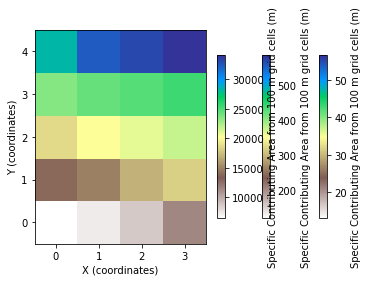

In [73]:
imshow_grid(grid,'topographic__specific_contributing_area', cmap='terrain_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Specific Contributing Area from 100 m grid cells', var_units='m')
imshow_grid(grid,'topographic__specific_contributing_area_small', cmap='terrain_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Specific Contributing Area from 100 m grid cells', var_units='m')
imshow_grid(grid,'topographic__specific_contributing_area_big', cmap='terrain_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Specific Contributing Area from 100 m grid cells', var_units='m')

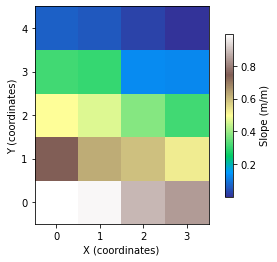

In [74]:
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')

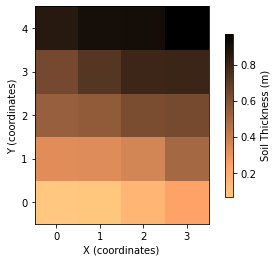

In [75]:
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

### Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 
##### Random iterations Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cell below to the number of iterations of your choice.  

In [76]:
n = 25

## Specify Recharge Distributions to compare four options

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We'll provide each of these recharge options below by specifying a recharge distribution and the necessary parameters. <br /> 
##### Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cells below to adjust the recharge distributions.

 ### 1. Recharge and Depth Options - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge and depth based on minimum and maximum recharge and depth values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and depth and instantiating the component.


In [77]:
T = grid['node']['soil__transmissivity'].min()
T

1.7132193102093636

In [78]:
a = grid['node']['topographic__specific_contributing_area'].max()
a

56.527328708102999

In [79]:
theta = np.sin(np.arctan(grid['node']['topographic__slope'])).min()
theta

0.0038664553399540003

In [80]:
hs = grid['node']['soil__thickness'] 
hs

array([ 0.06709033,  0.07529511,  0.14956269,  0.23817131,  0.33209866,
        0.33460934,  0.36570827,  0.50027231,  0.53979657,  0.55817702,
        0.62023867,  0.63481204,  0.63970881,  0.72680075,  0.79754558,
        0.8027728 ,  0.85592079,  0.90537465,  0.90992334,  0.9722531 ])

# Unit test calculations 
## Given one input value for recharge and depth forcings (meters)
## to solve for one value of relative wetness 
## then use the resulting Rw to back calculate and solve for the given forcing
## Expected output: algorithms solve the equations given a known value

In [81]:
print("Unit inputs for Recharge Forcing")
Re = 1 #meters
print("Recharge Re = {value} meter/day".format(value=Re))
T = grid['node']['soil__transmissivity'].mean()
T= 10 
print("Transmissivity T  = {value} meters/day in sandy soils".format(value=T))
a = grid['node']['topographic__specific_contributing_area'].mean()
a = 1 
print("Specific contributing area  = {value} meters".format(value=a))
theta = np.sin(np.arctan(grid['node']['topographic__slope'])).mean()
theta = 0.1
print("Slope  = {value} meter/meter".format(value=theta))
print("")
print("Calculate a unit of relative wetness: Recharge")
rw_Re = Re * a / (T * theta)
print("the Relative Wetness   = {value} (calculated with Recharge)".format(value=rw_Re))
Recharge = ((T * theta) * rw_Re ) / a
print("Check calculation that input Re is equivelent to solution using caculated Relative Wetness where Recharge  = {value} meter/day".format(value=Recharge))
print("")
print("")
print("Unit inputs for Depth Forcing for saturated conditions (by definition of Saturation = De <= 0.001 )")
De_sat_threshold = 0.001 #numerical approximation to accomodate precision of 'saturated depth to water'
De = 0.001  #Depth = hs - rel_wetness * hs
print("and assuming depth to water table De = {value} meter".format(value=De))
SoilThickness = 1  #Depth = hs - rel_wetness * hs
print("Soil Thickness = {value} meter".format(value=SoilThickness))
print("")
print("Calculate a unit of relative wetness: Depth")
hw = SoilThickness - De
rw_De =  (SoilThickness - De) / (SoilThickness-De_sat_threshold)
print("the Relative Wetness  = {value} (calculated with Depth)".format(value=rw_De))
Depth = SoilThickness - rw_De * SoilThickness
print("Check calculation that input De is equivelent to solution using calculated Relative Wetness where Depth  = {value} meter/day".format(value=Depth))
print("")
print("")
print("Unit inputs for Depth Forcing when soil is dry (by definition De = Soil Thickness)")
De_sat_threshold = 0.001 #numerical approximation to accomodate precision of 'saturated depth to water'
De = 1  #Depth = hs - rel_wetness * hs
print("and assuming depth to water table De = {value} meter".format(value=De))
SoilThickness = 1  #Depth = hs - rel_wetness * hs
print("Soil Thickness = {value} meter".format(value=SoilThickness))
print("")
print("Calculate a unit of relative wetness: Depth")
hw = SoilThickness - De
rw_De =  (SoilThickness - De) / (SoilThickness-De_sat_threshold)
print("the Relative Wetness  = {value} (calculated with Depth)".format(value=rw_De))
Depth = SoilThickness - rw_De * SoilThickness
print("Check calculation that input De is equivelent to solution using calculated Relative Wetness where Depth  = {value} meter/day".format(value=Depth))


Unit inputs for Recharge Forcing
Recharge Re = 1 meter/day
Transmissivity T  = 10 meters/day in sandy soils
Specific contributing area  = 1 meters
Slope  = 0.1 meter/meter

Calculate a unit of relative wetness: Recharge
the Relative Wetness   = 1.0 (calculated with Recharge)
Check calculation that input Re is equivelent to solution using caculated Relative Wetness where Recharge  = 1.0 meter/day


Unit inputs for Depth Forcing for saturated conditions (by definition of Saturation = De <= 0.001 )
and assuming depth to water table De = 0.001 meter
Soil Thickness = 1 meter

Calculate a unit of relative wetness: Depth
the Relative Wetness  = 1.0 (calculated with Depth)
Check calculation that input De is equivelent to solution using calculated Relative Wetness where Depth  = 0.0 meter/day


Unit inputs for Depth Forcing when soil is dry (by definition De = Soil Thickness)
and assuming depth to water table De = 1 meter
Soil Thickness = 1 meter

Calculate a unit of relative wetness: Depth
the

In [82]:

print("Unit inputs for Recharge Forcing where 0 < Rw < 1 ")
Re = 0.5 #meters
print("Recharge Re = {value} meter/day".format(value=Re))
T = grid['node']['soil__transmissivity'].mean()
T= 10 
print("Transmissivity T  = {value} meters/day in sandy soils".format(value=T))
a = grid['node']['topographic__specific_contributing_area'].mean()
a = 1 
print("Specific contributing area  = {value} meters".format(value=a))
theta = np.sin(np.arctan(grid['node']['topographic__slope'])).mean()
theta = 0.1
print("Slope  = {value} meter/meter".format(value=theta))
print("")
print("Calculate a unit of relative wetness: Recharge")
rw_Re = Re * a / (T * theta)
print("the Relative Wetness   = {value} (calculated with Recharge)".format(value=rw_Re))
Recharge = ((T * theta) * rw_Re ) / a
print("Check calculation that input Re is equivelent to solution using caculated Relative Wetness where Recharge  = {value} meter/day".format(value=Recharge))
print("")
print("")
print("Unit inputs for Depth Forcing where 0 < Rw < 1 ")
De_sat_threshold = 0.001 #numerical approximation to accomodate precision of 'saturated depth to water'
De = 0.5  #Depth = hs - rel_wetness * hs
print("and assuming depth to water table De = {value} meter".format(value=De))
SoilThickness = 1  #Depth = hs - rel_wetness * hs
print("Soil Thickness = {value} meter".format(value=SoilThickness))
print("")
print("Calculate a unit of relative wetness: Depth")
hw = SoilThickness - De
rw_De =  (SoilThickness - De) / (SoilThickness-De_sat_threshold)
print("the Relative Wetness  = {value} (calculated with Depth)".format(value=rw_De))
Depth = SoilThickness - rw_De * SoilThickness
print("Check calculation that input De is equivelent to solution using calculated Relative Wetness where Depth  = {value} meter/day".format(value=Depth))


Unit inputs for Recharge Forcing where 0 < Rw < 1 
Recharge Re = 0.5 meter/day
Transmissivity T  = 10 meters/day in sandy soils
Specific contributing area  = 1 meters
Slope  = 0.1 meter/meter

Calculate a unit of relative wetness: Recharge
the Relative Wetness   = 0.5 (calculated with Recharge)
Check calculation that input Re is equivelent to solution using caculated Relative Wetness where Recharge  = 0.5 meter/day


Unit inputs for Depth Forcing where 0 < Rw < 1 
and assuming depth to water table De = 0.5 meter
Soil Thickness = 1 meter

Calculate a unit of relative wetness: Depth
the Relative Wetness  = 0.5005005005005005 (calculated with Depth)
Check calculation that input De is equivelent to solution using calculated Relative Wetness where Depth  = 0.49949949949949946 meter/day


In [83]:
def scenario_unit_explorer_print(rel_wet,Scenario,a,T,theta):

    print("topographic__specific_contributing_area= {value} ".format(value=a))

    if Scenario == "Dry":
        #Dry Variables  Recharge in mm/day
        rel_wetness = rel_wet

        Recharge = (rel_wetness * (T * theta )) / a
        print(Recharge)

        Remin_value = Recharge.min()
        Remean = Recharge.mean()
        Restandard_deviation =  Recharge.std()
        Remax_value =  Recharge.max()

        #print ("{index}. {word} appears {count} times".format(index=1, word='Hello', count=42))
        print("Dry Remin_value = {value} ".format(value=Remin_value))
        print("Dry Remean = {value} ".format(value=Remean))
        print("Dry Restandard_deviation = {value} ".format(value=Restandard_deviation))
        print("Dry Remax_value = {value} ".format(value=Remax_value))

        rw = Recharge * a / (T * theta)

        print(rw)

        Scenario_R=[Remin_value,Remax_value]

        #Dry Variables   Depth in meters
        De_sat_threshold = 0.001
        Depth = hs - rel_wetness * hs
        rw =  (hs - Depth) / (hs-De_sat_threshold)
        hw = hs - Depth
        print("Depth to groundwater= {value} ".format(value=Depth))
        print("Height of water= {value} ".format(value=hw))
        print("Relative Wetness= {value} ".format(value=rw))

        Demin_value = Depth.min()
        Demean = Depth.mean()
        Destandard_deviation =  Depth.std()
        Demax_value =  Depth.max()
        print("Dry Demin_value = {value} ".format(value=Demin_value))
        print("Dry Demean = {value} ".format(value=Demean))
        print("Dry Destandard_deviation = {value} ".format(value=Destandard_deviation))
        print("Dry Demax_value = {value} ".format(value=Demax_value))

        Scenario_D=[Demin_value,Demax_value]

    elif Scenario == "Wet":
        #Wet Variables  Recharge in mm/day
        rel_wetness = rel_wet

        Recharge = (rel_wetness * (T * theta )) / a
        print(Recharge)

        Remin_value = Recharge.min()
        Remean = Recharge.mean()
        Restandard_deviation =  Recharge.std()
        Remax_value =  Recharge.max()

        #print ("{index}. {word} appears {count} times".format(index=1, word='Hello', count=42))
        print("Wet Remin_value = {value} ".format(value=Remin_value))
        print("Wet Remean = {value} ".format(value=Remean))
        print("Wet Restandard_deviation = {value} ".format(value=Restandard_deviation))
        print("Wet Remax_value = {value} ".format(value=Remax_value))

        rw = Recharge * a / (T * theta)

        print(rw)

        Scenario_R=[Remin_value,Remax_value]

        #Wet Variables   Depth in meters
        De_sat_threshold = 0.001
        Depth = hs - rel_wetness * hs
        rw =  (hs - Depth) / (hs-De_sat_threshold)
        hw = hs - Depth
        print("Depth to groundwater= {value} ".format(value=Depth))
        print("Height of water= {value} ".format(value=hw))
        print("Relative Wetness= {value} ".format(value=rw))

        Demin_value = Depth.min()
        Demean = Depth.mean()
        Destandard_deviation =  Depth.std()
        Demax_value =  Depth.max()
        print("Wet Demin_value = {value} ".format(value=Demin_value))
        print("Wet Demean = {value} ".format(value=Demean))
        print("Wet Destandard_deviation = {value} ".format(value=Destandard_deviation))
        print("Wet Demax_value = {value} ".format(value=Demax_value))

        Scenario_D=[Demin_value,Demax_value]
        
        return Scenario_R

In [124]:
def scenario_unit_explorer(rel_wet,Scenario,a,T,theta):
    print("For the {value1} scenario with relative wetness = {value2}".format(value1=Scenario,value2=rel_wet))
    print(" Mean topographic__specific_contributing_area= {value_mean} ".format(value_mean=a.mean()))

    if Scenario == "Dry":
        #Dry Variables  Recharge in mm/day
        rel_wetness = rel_wet

        Recharge = (rel_wetness * (T * theta )) / a

        Remin_value = Recharge.min()
        Remean = Recharge.mean()
        Restandard_deviation =  Recharge.std()
        Remax_value =  Recharge.max()
        rw = Recharge * a / (T * theta)

        Scenario_R=[Remin_value,Remax_value,Remean,Restandard_deviation]

        #Dry Variables   Depth in meters
        De_sat_threshold = 0.001
        Depth = hs - rel_wetness * hs
        rw =  (hs - Depth) / (hs-De_sat_threshold)
        hw = hs - Depth
 
        Demin_value = Depth.min()
        Demean = Depth.mean()
        Destandard_deviation =  Depth.std()
        Demax_value =  Depth.max()

        Scenario_D=[Demin_value,Demax_value,Demean,Destandard_deviation]

    elif Scenario == "Wet":
        #Wet Variables  Recharge in mm/day
        rel_wetness = rel_wet

        Recharge = (rel_wetness * (T * theta )) / a
        
        Remin_value = Recharge.min()
        Remean = Recharge.mean()
        Restandard_deviation =  Recharge.std()
        Remax_value =  Recharge.max()

        rw = Recharge * a / (T * theta)

        Scenario_R=[Remin_value,Remax_value,Remean,Restandard_deviation]

        #Wet Variables   Depth in meters
        De_sat_threshold = 0.001
        Depth = hs - rel_wetness * hs
        rw =  (hs - Depth) / (hs-De_sat_threshold)
        hw = hs - Depth

        Demin_value = Depth.min()
        Demean = Depth.mean()
        Destandard_deviation =  Depth.std()
        Demax_value =  Depth.max()

        Scenario_D=[Demin_value,Demax_value,Demean,Destandard_deviation]
    
    print("Recharge min, max, mean, std  should be {value1} [min,max,mean,std] meters/day".format(value1=Scenario_R))
    print("Depth min, max, mean, std should be {value1} [min,max,mean,std] meters".format(value1=Scenario_D))
    return Scenario_R, Scenario_D

In [125]:
#Wet Scenario solving for distribution of values
T = grid['node']['soil__transmissivity']

theta = np.sin(np.arctan(grid['node']['topographic__slope']))
hs = grid['node']['soil__thickness'] 
a_unit = grid['node']['topographic__specific_contributing_area']
a_small = grid['node']['topographic__specific_contributing_area_small']
a_big = grid['node']['topographic__specific_contributing_area_big']

#Unit area 10 m grid
Scenario="Wet"
rel_wet = 1 
[scenarioR_wet_unit,scenarioD_wet_unit]=scenario_unit_explorer(rel_wet,Scenario,a_unit,T,theta)
print("")
Scenario="Dry"
rel_wet = 0.1
[scenarioR_dry_unit,scenarioD_dry_unit]=scenario_unit_explorer(rel_wet,Scenario,a_unit,T,theta)   
print("")
#Unit area 100 m grid
Scenario="Wet"
rel_wet = 1 
[scenarioR_wet_small,scenarioD_wet_small]=scenario_unit_explorer(rel_wet,Scenario,a_small,T,theta)
print("")
Scenario="Dry"
rel_wet = 0.1
[scenarioR_dry_small,scenarioD_dry_small]=scenario_unit_explorer(rel_wet,Scenario,a_small,T,theta)   
print("")
#Unit area 6000 m grid
Scenario="Wet"
rel_wet = 1 
[scenarioR_wet_big,scenarioD_wet_big]=scenario_unit_explorer(rel_wet,Scenario,a_big,T,theta)
print("")
Scenario="Dry"
rel_wet = 0.1
[scenarioR_dry_big,scenarioD_dry_big]=scenario_unit_explorer(rel_wet,Scenario,a_big,T,theta)   
print("")

#Select a test to compare R and D min/max bounds
#Unit area 10 m grid
Scenario="Wet"
rel_wet = 0.7 
[Scenario_R,Scenario_D]=scenario_unit_explorer(rel_wet,Scenario,a_unit,T,theta)
print("")

For the Wet scenario with relative wetness = 1
 Mean topographic__specific_contributing_area= 34.98006461244037 
Recharge min, max, mean, std  should be [0.00066421042521528772, 0.092017716070105601, 0.050579313882431531, 0.030271375363178442] [min,max,mean,std] meters/day
Depth min, max, mean, std should be [0.0, 0.0, 0.0, 0.0] [min,max,mean,std] meters

For the Dry scenario with relative wetness = 0.1
 Mean topographic__specific_contributing_area= 34.98006461244037 
Recharge min, max, mean, std  should be [6.6421042521528772e-05, 0.0092017716070105608, 0.0050579313882431537, 0.0030271375363178444] [min,max,mean,std] meters/day
Depth min, max, mean, std should be [0.060381293714049378, 0.87502778917353163, 0.49617594631719558, 0.25062274802781531] [min,max,mean,std] meters

For the Wet scenario with relative wetness = 1
 Mean topographic__specific_contributing_area= 375.9779690535743 
Recharge min, max, mean, std  should be [6.4065516445205669e-05, 0.010493759651466435, 0.004833460463

In [86]:
# See soil thickness above set from a range of 0.1 to 3 meters

distribution1 = 'uniform'

LS_prob1_r = LandslideProbability(grid_r,number_of_iterations=n,
    groundwater__recharge_distribution=distribution1,
    groundwater__recharge_min_value=Scenario_R[0],
    groundwater__recharge_max_value=Scenario_R[1])

LS_prob1_d = LandslideProbability(grid_d,number_of_iterations=n,
    groundwater__depth_distribution=distribution1,
    groundwater__depth_min_value=Scenario_D[0],
    groundwater__depth_max_value=Scenario_D[1])


### 2. Recharge and Depth Options - 'lognormal' distribution

In this option, we specify a lognormal distribution with a recharge and depth mean and standard deviation values.  We instantiate the LandslideProbabilty class to create a new object or 'instance' of the class/component LandslideProbability. So now we have created two instances.

In [87]:
distribution2 = 'lognormal'

LS_prob2_r = LandslideProbability(grid_r,number_of_iterations=n,
    groundwater__recharge_distribution=distribution2,
    groundwater__recharge_mean=Scenario_R[2],
    groundwater__recharge_standard_deviation=Scenario_R[3])


In [88]:
distribution2 = 'lognormal'


LS_prob2_d = LandslideProbability(grid_d,number_of_iterations=n,
    groundwater__depth_distribution=distribution2,
    groundwater__depth_mean=Scenario_D[2],
    groundwater__depth_standard_deviation=Scenario_D[3])


### 3. Recharge and Depth Options - 'lognormal_spatial' distribution

Similar to the previous option (#2), we use a lognormal distribution for recharge and depth.  However, in this case we provide arrays to represent mean and standard deviation values for each node in our grid.  Thus, the distribution varies for each node - representing a spatially varying distribution of recharge and depth.

In [89]:
distribution3 = 'lognormal_spatial'
Remean3 = np.random.uniform(Scenario_R[0],Scenario_R[1],grid_size)
Restandard_deviation3 = np.random.rand(grid_size)
LS_prob3_r = LandslideProbability(grid_r,number_of_iterations=n,
    groundwater__recharge_distribution=distribution3,
    groundwater__recharge_mean=Remean3,
    groundwater__recharge_standard_deviation=Restandard_deviation3)

Demean3 = np.random.uniform(Scenario_D[0],Scenario_D[1],grid_size)
Destandard_deviation3 = np.random.rand(grid_size)
LS_prob3_d = LandslideProbability(grid_d,number_of_iterations=n,
    groundwater__depth_distribution=distribution3,
    groundwater__depth_mean=Demean3,
    groundwater__depth_standard_deviation=Destandard_deviation3)


### 4. Recharge and Depth 'data_driven_spatial' distributions 

### Generate Recharge input option 

This is the most complex representation of recharge used in the LandslideProbability component.  
In this case, we provide recharge distributions (arrays) directly that are unique for each node.  

In a real-world situation, we would acquire these from a hydrologic model that often has a coarser resolution than our grid.<br />
Thus, we route the recharge data arrays from these larger Hydraulic Source Domain (HSD) grids down to each node of our grid. Landlab has a 'Source tracking algorithm' utility that performs this routing and produces Python dictionaries (_key: value_ pairs) that become parameters for the 'data_driven_spatial' recharge distribution.  In this synthetic example, we'll generate synthetic versions of these dictionaries.

In [90]:
HSD_dict = {}
for vkey in range(2,8):  #the first example vkey =2 is printed below
    HSD_dict[vkey] = np.random.uniform(Scenario_R[0],Scenario_R[1],10)    # 20 - 120 mm/day 
print('HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). ')    
print('The entire synthetic dictionary is:')
print(HSD_dict)
print('The array for the HSD vkey = 2 of this unordered dictionary is:')
print(HSD_dict[2])

HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). 
The entire synthetic dictionary is:
{2: array([ 0.03556017,  0.04619949,  0.03901013,  0.03530884,  0.02755659,
        0.04176823,  0.02844754,  0.05749156,  0.06208873,  0.02498506]), 3: array([ 0.05109375,  0.03428643,  0.03678995,  0.0596545 ,  0.00500752,
        0.00603664,  0.00175786,  0.05370887,  0.05022609,  0.05610001]), 4: array([ 0.0630451 ,  0.0515691 ,  0.02997538,  0.0503778 ,  0.0080283 ,
        0.04138627,  0.00963203,  0.06087412,  0.03383582,  0.02698152]), 5: array([ 0.01738261,  0.04997522,  0.0296346 ,  0.03681485,  0.00166651,
        0.03996116,  0.03960691,  0.03991631,  0.06081523,  0.04406562]), 6: array([ 0.02345456,  0.02841203,  0.04507669,  0.00431621,  0.04310298,
        0.04335053,  0.01391838,  0.00870946,  0.02063579,  0.02372333]), 7: array([ 0.03692758,  0.0285124 ,  0.06366894,  0.00699045,  0.01382208,
     

***Note: this is a much lower recharge than the uniform.

HSD_ID dictionary has the grid node ID as ‘keys’ and HSD IDs in a list as ‘values’. 

In [91]:
HSD_id_dict = {}
for ckey in grid.core_nodes:
    HSD_id_dict[ckey] = np.random.randint(2,8,2)
print('The entire ID synthetic dictionary is:')
print(HSD_id_dict)
print('The array for the ckey = 5, the first index of core nodes in the dictionary is:')
print(HSD_id_dict[5])
print('The two values in the array are the multiple vkeys that correspond/drain to the ckey:')


The entire ID synthetic dictionary is:
{5: array([7, 7]), 6: array([7, 2]), 9: array([3, 7]), 10: array([3, 5]), 13: array([2, 7]), 14: array([2, 3])}
The array for the ckey = 5, the first index of core nodes in the dictionary is:
[7 7]
The two values in the array are the multiple vkeys that correspond/drain to the ckey:


The fractions dictionary assigns to each node ID as ‘key’ a lists the fractions of each HSD draining to the node as ‘values’. 

In [92]:
fract_dict = {}
for ckey in grid.core_nodes:
    fract_dict[ckey] =  np.random.rand(2)
print('The entire ID synthetic dictionary is:')
print(fract_dict)
print('The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:')
print(fract_dict[5])

The entire ID synthetic dictionary is:
{5: array([ 0.83794491,  0.09609841]), 6: array([ 0.97645947,  0.4686512 ]), 9: array([ 0.97676109,  0.60484552]), 10: array([ 0.73926358,  0.03918779]), 13: array([ 0.28280696,  0.12019656]), 14: array([ 0.2961402 ,  0.11872772])}
The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:
[ 0.83794491  0.09609841]


When the component is instantiated, the three dictionaries are provided as the 'parameters' for the distribution in explicit order.

### Generate Depth to water table Input option

In [93]:
key=np.arange(grid.number_of_nodes)
HSD_inputs_d={}

for i in range(grid.number_of_nodes):
    annualmaxDWT=np.random.uniform(Scenario_D[0],Scenario_D[1],10)
    HSD_inputs_d[i] = (annualmaxDWT)

#print(HSD_inputs_d)
print('The values assigned to the first node (key) are: ')
print(HSD_inputs_d[0])

The values assigned to the first node (key) are: 
[ 0.10647506  0.13261973  0.03754628  0.20816709  0.17398706  0.0921933
  0.1622145   0.04563653  0.1765247   0.27247639]


### Calculate landslide component input distributions

In [94]:
distribution4 = 'data_driven_spatial'

HSD_inputs_r = [HSD_dict,HSD_id_dict,fract_dict]
LS_prob4_r = LandslideProbability(grid_r,number_of_iterations=n,
    groundwater__recharge_distribution=distribution4,
    groundwater__recharge_HSD_inputs=HSD_inputs_r)

LS_prob4_d = LandslideProbability(grid_d,number_of_iterations=n,
    groundwater__depth_distribution=distribution4,
    groundwater__depth_HSD_inputs=HSD_inputs_d)


## Run the Landslide Component 

To generate the outputs from running the component, we call the 'calculate_landslide_probability' method inside the component using the class instance (e.g., LS_prob1) for each recharge option specified above. The following cell runs the model; in the following section we will assessing the results.

###  Run the Landslide Component in Default Parameters for Depth Forcing Uniform Distribution

Uniform recharge; default parameters.

In [95]:
LS_prob1_d.calculate_landslide_probability()

The outputs of model simulations are:

In [96]:
sorted(LS_prob1_d.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

These model output arrays are attached to the grid as fields. When we run the model for a different recharge, these fields are over-written. 

###  Run the Landslide Component and Save Outputs for Four Different Modes

Run the remaining three recharge options and save the arrays as variables for plotting.

In [97]:
sorted(LandslideProbability.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

In [98]:
LS_prob1_r.calculate_landslide_probability()
LS_prob1_r_probability_of_failure = grid_r.at_node['landslide__probability_of_failure']
LS_prob1_r_relative_wetness = grid_r.at_node['soil__mean_relative_wetness']
LS_prob1_r_probability_of_saturation = grid_r.at_node['soil__probability_of_saturation']
LS_prob1_r_mean_watertable_depth = grid_r.at_node['soil__mean_watertable_depth']




/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:777: RuntimeWarning: invalid value encountered in less


In [99]:
#this a repeat of the same inputs above, but with resampling and a different result

LS_prob1_d.calculate_landslide_probability()
LS_prob1_d_probability_of_failure = grid_d.at_node['landslide__probability_of_failure']
LS_prob1_d_relative_wetness = grid_d.at_node['soil__mean_relative_wetness']
LS_prob1_d_probability_of_saturation = grid_d.at_node['soil__probability_of_saturation']
LS_prob1_d_mean_watertable_depth = grid_d.at_node['soil__mean_watertable_depth']

In [100]:
sorted(LS_prob1_r.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

Depth Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.84  0.76  0.    0.    0.4   0.04  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Depth Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.46179867
  0.50769148  0.          0.          0.67775234  0.71004881  0.
  0.          0.75261945  0.77459045  0.          0.          0.
  0.          0.        ]
Depth Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Depth Forcing Input; soil__mean_watertable_depth output
[ 0.          0.          0.          0.          0.          0.18054898
  0.18054898  0.          0.          0.18054898  0.18054898  0.
  0.          0.18054898  0.18054898  0.          0.          0.
  0.          0.        ]


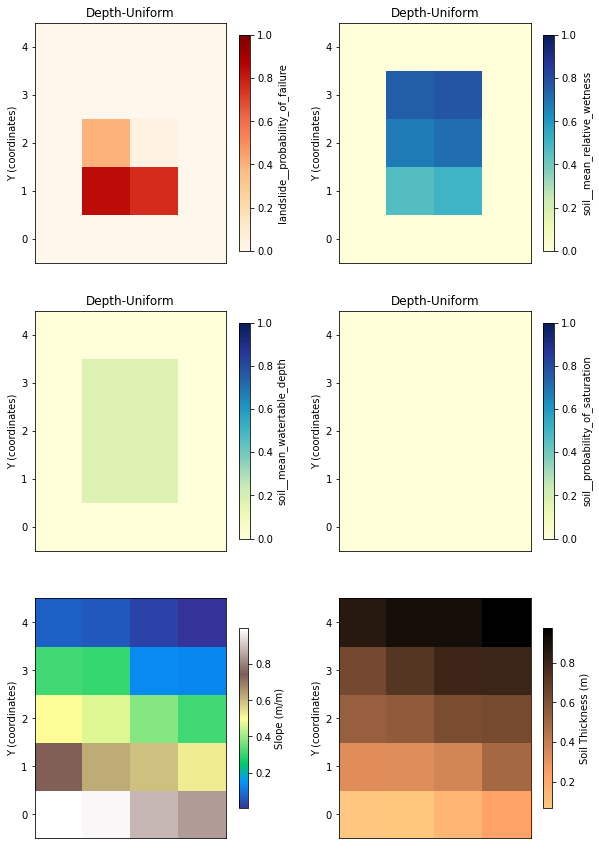

In [101]:
cbar_list=sorted(LS_prob1_d.output_var_names)
dist_list=['Depth-Uniform','Depth-Uniform','Depth-Uniform','Depth-Uniform']
cmapWet = 'YlGnBu'

cmapFailure='OrRd'
inputgrid=grid_d
ax1=[]
ax2=[]
ax3=[]
ax4=[]

fig = plt.figure('Plot Component Outputs for one forcing option (Depth) and one distribution Option (Uniform)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [dist_list[0],dist_list[1],dist_list[2],dist_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

    
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)
        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9,
                        var_name=cbar_name)
        
        
ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Depth Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Depth Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Depth Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])
print('Depth Forcing Input; soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    

#TO DO 
#Save Core Nodes to a spreadsheet

In [102]:
sorted(LS_prob1_r.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

Recharge Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.28  0.2   0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Recharge Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.00055553
  0.00059558  0.          0.          0.00069412  0.00090815  0.
  0.          0.00114768  0.00227422  0.          0.          0.
  0.          0.        ]
Recharge Forcing Input; NOT CALCULATED soil__mean_watertable_depth output
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan]
Recharge Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


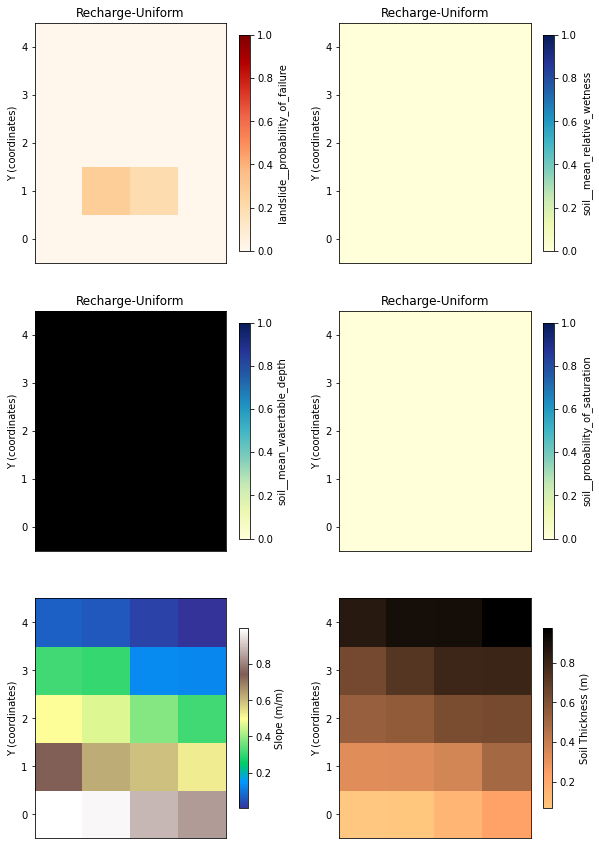

In [103]:
cbar_list=sorted(LS_prob1_r.output_var_names)

dist_list=['Recharge-Uniform','Recharge-Uniform','Recharge-Uniform','Recharge-Uniform']

cmapFailure='OrRd'

inputgrid=grid_r

fig = plt.figure('Plot Component Outputs for one forcing option (Depth) and one distribution Option (Uniform)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [dist_list[0],dist_list[1],dist_list[2],dist_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

        
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)

        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9, 
                        var_name=cbar_name)
        

ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Recharge Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Recharge Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Recharge Forcing Input; NOT CALCULATED soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    
print('Recharge Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])

#TO DO 
#Save Core Nodes to a spreadsheet

Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. 

This simulation generates a probability value for each core node. 

In [104]:
LS_prob1_r_probability_of_failure = grid_r.at_node['landslide__probability_of_failure']
grid_r.at_node['landslide__probability_of_failure']

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.28,  0.2 ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

In [105]:
LS_prob1_d_probability_of_failure = grid_d.at_node['landslide__probability_of_failure']
grid_d.at_node['landslide__probability_of_failure']

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.84,  0.76,  0.  ,  0.  ,
        0.4 ,  0.04,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

This simulation generates a mean relative wetness value for each core node.

In [106]:
LS_prob1_r_relative_wetness = grid_r.at_node['soil__mean_relative_wetness']
grid_r.at_node['soil__mean_relative_wetness']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00055553,  0.00059558,  0.        ,  0.        ,  0.00069412,
        0.00090815,  0.        ,  0.        ,  0.00114768,  0.00227422,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [107]:
LS_prob1_d_relative_wetness = grid_d.at_node['soil__mean_relative_wetness']
grid_d.at_node['soil__mean_relative_wetness']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.46179867,  0.50769148,  0.        ,  0.        ,  0.67775234,
        0.71004881,  0.        ,  0.        ,  0.75261945,  0.77459045,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

***Note: these will have the values on the grid over write LS_prob0 values...still same grid_r or grid_d

In [108]:
LS_prob2_r.calculate_landslide_probability()
LS_prob2_r_probability_of_failure = grid_r.at_node['landslide__probability_of_failure']
LS_prob2_r_relative_wetness = grid_r.at_node['soil__mean_relative_wetness']

LS_prob2_d.calculate_landslide_probability()
LS_prob2_d_probability_of_failure = grid_d.at_node['landslide__probability_of_failure']
LS_prob2_d_relative_wetness = grid_d.at_node['soil__mean_relative_wetness']


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:777: RuntimeWarning: invalid value encountered in less


In [109]:
LS_prob3_r.calculate_landslide_probability()
LS_prob3_r_probability_of_failure = grid_r.at_node['landslide__probability_of_failure']
LS_prob3_r_relative_wetness = grid_r.at_node['soil__mean_relative_wetness']

LS_prob3_d.calculate_landslide_probability()
LS_prob3_d_probability_of_failure = grid_d.at_node['landslide__probability_of_failure']
LS_prob3_d_relative_wetness = grid_d.at_node['soil__mean_relative_wetness']


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:777: RuntimeWarning: invalid value encountered in less


In [110]:
LS_prob4_r.calculate_landslide_probability()
LS_prob4_r_probability_of_failure = grid_r.at_node['landslide__probability_of_failure']
LS_prob4_r_relative_wetness = grid_r.at_node['soil__mean_relative_wetness']


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:777: RuntimeWarning: invalid value encountered in less


In [111]:
LS_prob4_d.calculate_landslide_probability()
LS_prob4_d_probability_of_failure = grid_d.at_node['landslide__probability_of_failure']
LS_prob4_d_relative_wetness = grid_d.at_node['soil__mean_relative_wetness']

Recharge Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.28  0.12  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Recharge Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.00038725
  0.00078355  0.          0.          0.00101948  0.00077246  0.
  0.          0.00044147  0.00111335  0.          0.          0.
  0.          0.        ]
Recharge Forcing Input; NOT CALCULATED soil__mean_watertable_depth output
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan]
Recharge Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


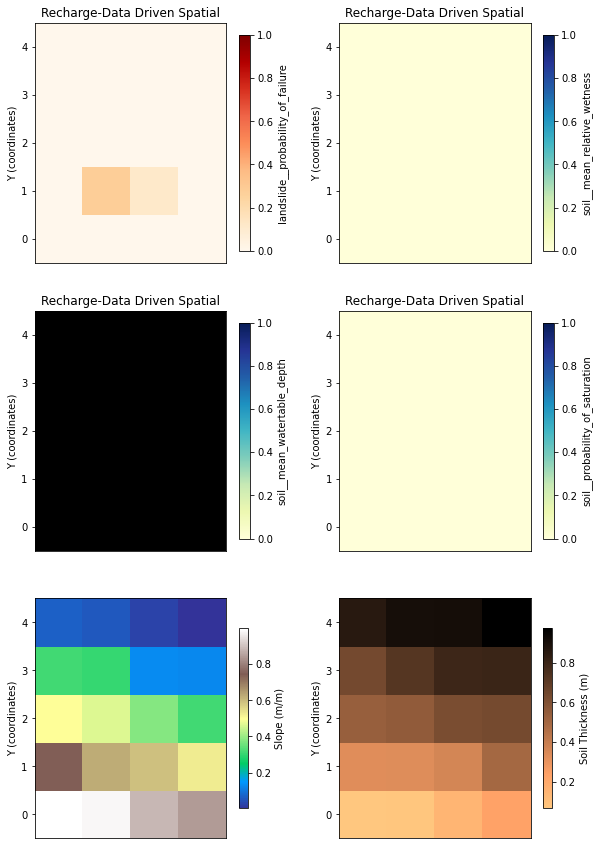

In [112]:
cbar_list=sorted(LS_prob1_r.output_var_names)

dist_list=['Recharge-Data Driven Spatial','Recharge-Data Driven Spatial','Recharge-Data Driven Spatial','Recharge-Data Driven Spatial']

cmapFailure='OrRd'

inputgrid=grid_r

fig = plt.figure('Plot Component Outputs for one forcing option (Depth) and one distribution Option (Data Driven Spatial)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [dist_list[0],dist_list[1],dist_list[2],dist_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

        
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)

        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9, 
                        var_name=cbar_name)
        

ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Recharge Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Recharge Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Recharge Forcing Input; NOT CALCULATED soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    
print('Recharge Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])

#TO DO 
#Save Core Nodes to a spreadsheet

Depth Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.92  0.72  0.    0.    0.68  0.12  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Depth Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.50291812
  0.44059736  0.          0.          0.80328459  0.72621725  0.
  0.          0.7498946   0.7377542   0.          0.          0.
  0.          0.        ]
Depth Forcing Input; soil__mean_watertable_depth output
[ 0.          0.          0.          0.          0.          0.15460965
  0.20572467  0.          0.          0.12389138  0.16451189  0.
  0.          0.15686586  0.19100928  0.          0.          0.
  0.          0.        ]
Depth Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


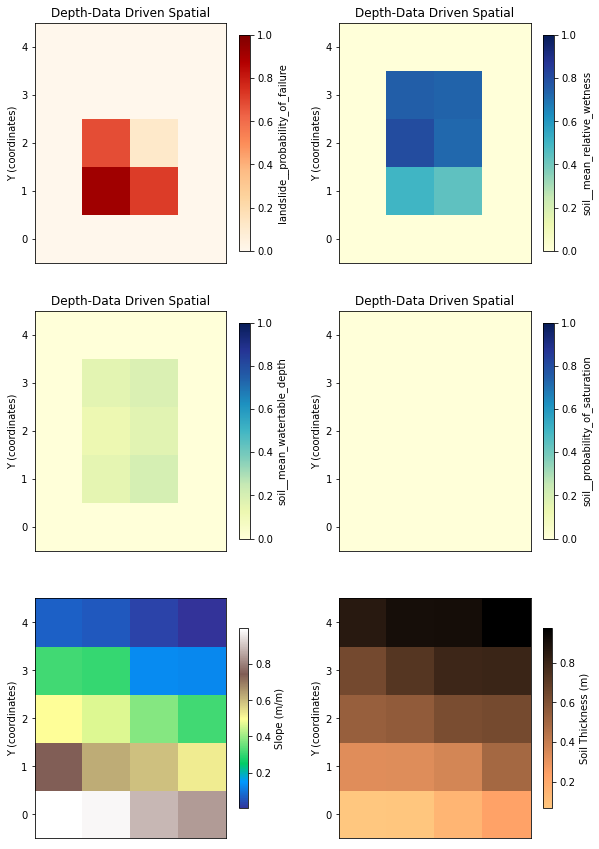

In [113]:
cbar_list=sorted(LS_prob1_d.output_var_names)

dist_list=['Depth-Data Driven Spatial','Depth-Data Driven Spatial','Depth-Data Driven Spatial','Depth-Data Driven Spatial']

cmapFailure='OrRd'

inputgrid=grid_d

fig = plt.figure('Plot Component Outputs for one forcing option (Depth) and one distribution Option (Data Driven Spatial)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [dist_list[0],dist_list[1],dist_list[2],dist_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

        
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)

        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,
                        grid_units=('coordinates','coordinates'), shrink=0.9, 
                        limits=(0, 1),  
                        var_name=cbar_name)
        


ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Depth Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Depth Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Depth Forcing Input; soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    
print('Depth Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])

#TO DO 
#Save Core Nodes to a spreadsheet

## View the  Landslide Outputs with Default Parameters 

### Visualization Input: Compare Two Input Options for the same output variable
    

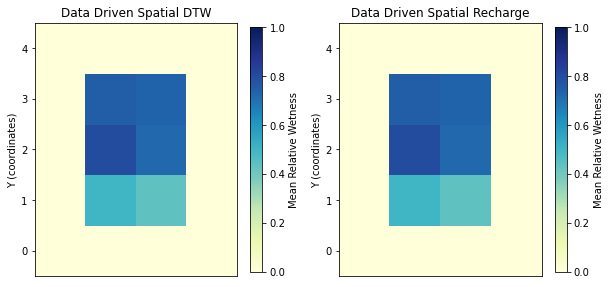

In [114]:

cmapWet = 'YlGnBu'

cbar_name='Mean Relative Wetness'

fig = plt.figure('Compare Component Options: Recharge vs. Depth')


for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([grid_d,grid_r],
                                                  [LS_prob4_d_relative_wetness,LS_prob4_d_relative_wetness],
                                                  ['Data Driven Spatial DTW','Data Driven Spatial Recharge'],
                                                  [cmapWet,cmapWet],
                                                  [cbar_name,cbar_name],
                                                  [121,122],
                                                  [ax1,ax2]):

    
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)
        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9,
                        var_name=cbar_name)
    
        

fig.set_size_inches(10,5)
    


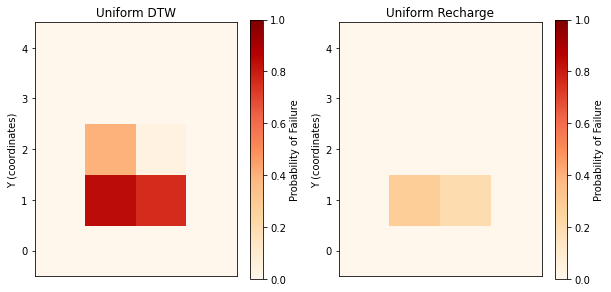

In [115]:
cbar_name='Probability of Failure'
cmapFailure='OrRd'

fig = plt.figure('Compare Component Options: Recharge vs. Depth')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([grid_d,grid_r],
                                                  [LS_prob1_d_probability_of_failure,LS_prob1_r_probability_of_failure],
                                                  ['Uniform DTW','Uniform Recharge'],
                                                  [cmapFailure,cmapFailure],
                                                  [cbar_name,cbar_name],
                                                  [121,122],
                                                  [ax1,ax2]):

    
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)
        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9,
                        var_name=cbar_name)
        plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
        

fig.set_size_inches(10,5)
    


Recharge Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.28  0.12  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Recharge Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.00038725
  0.00078355  0.          0.          0.00101948  0.00077246  0.
  0.          0.00044147  0.00111335  0.          0.          0.
  0.          0.        ]
Recharge Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Recharge Forcing Input; soil__mean_watertable_depth output
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan]


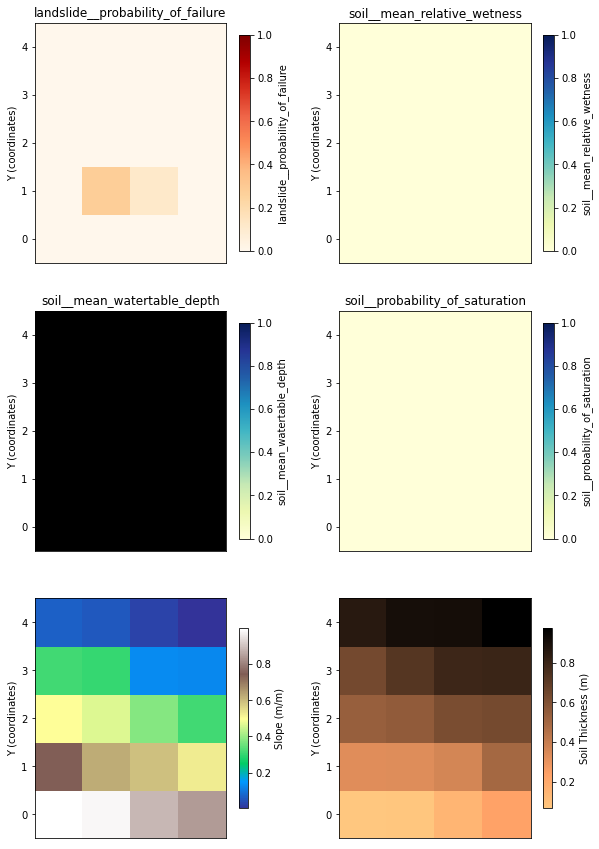

In [116]:
cbar_list=sorted(LS_prob1_r.output_var_names)

cmapFailure='OrRd'
inputgrid=grid_r

fig = plt.figure('Plot Component Outputs for one forcing option (Recharge) and one distribution Option (Uniform)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

    
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)
        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9,
                        var_name=cbar_name)

ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Recharge Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Recharge Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Recharge Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])
print('Recharge Forcing Input; soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    

#TO DO 
#Save Core Nodes to a spreadsheet

Depth Forcing Input; landslide__probability_of_failure output
[ 0.    0.    0.    0.    0.    0.92  0.72  0.    0.    0.68  0.12  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
Depth Forcing Input; soil__mean_relative_wetness output
[ 0.          0.          0.          0.          0.          0.50291812
  0.44059736  0.          0.          0.80328459  0.72621725  0.
  0.          0.7498946   0.7377542   0.          0.          0.
  0.          0.        ]
Depth Forcing Input; soil__probability_of_saturation output
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Depth Forcing Input; soil__mean_watertable_depth output
[ 0.          0.          0.          0.          0.          0.15460965
  0.20572467  0.          0.          0.12389138  0.16451189  0.
  0.          0.15686586  0.19100928  0.          0.          0.
  0.          0.        ]


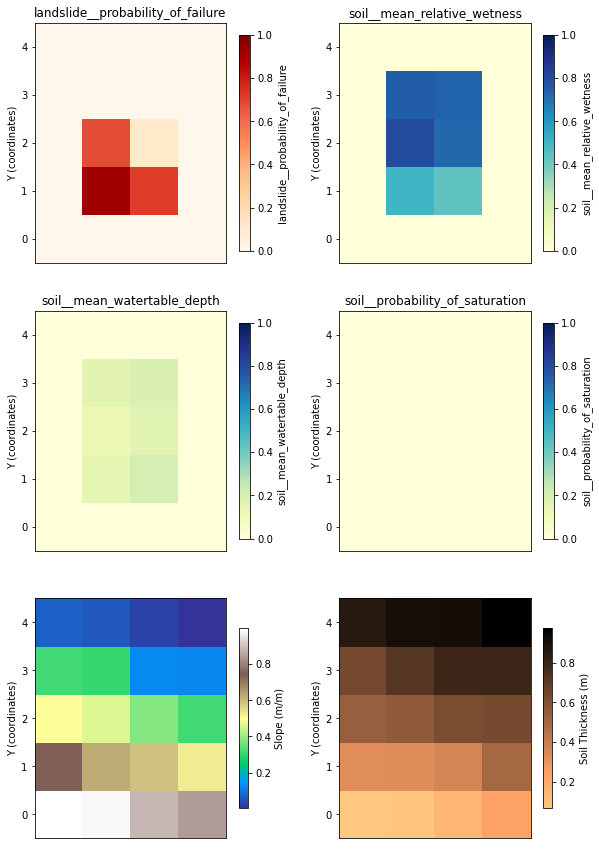

In [117]:
cbar_list=sorted(LS_prob1_d.output_var_names)

cmapFailure='OrRd'
inputgrid=grid_d

fig = plt.figure('Plot Component Outputs for one forcing option (Depth) and one distribution Option (Uniform)')

for eachgrid, outvar, plot_name, cmap, cbar_name, littleplots,axeslist in zip([inputgrid,inputgrid,inputgrid,inputgrid],
                                                  [inputgrid.at_node['landslide__probability_of_failure'],
                                                   inputgrid.at_node['soil__mean_relative_wetness'],
                                                   inputgrid.at_node['soil__mean_watertable_depth'],
                                                   inputgrid.at_node['soil__probability_of_saturation']],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [cmapFailure,cmapWet,cmapWet,cmapWet],
                                                  [cbar_list[0],cbar_list[1],cbar_list[2],cbar_list[3]],
                                                  [321,322,323,324],
                                                  [ax1,ax2,ax3,ax4]):

    
        axeslist = fig.add_subplot(littleplots)
        axeslist.xaxis.set_visible(False)
        imshow_grid(eachgrid, outvar, plot_name=plot_name,
                        allow_colorbar=True, cmap=cmap,limits=(0, 1),
                        grid_units=('coordinates','coordinates'), shrink=0.9,
                        var_name=cbar_name)

ax5 = fig.add_subplot(325)
ax5.xaxis.set_visible(False)        
imshow_grid(grid,'topographic__slope', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
ax6 = fig.add_subplot(326)
ax6.xaxis.set_visible(False)           
imshow_grid(grid,'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')

fig.set_size_inches(10,15)

print('Depth Forcing Input; landslide__probability_of_failure output')
print(inputgrid.at_node['landslide__probability_of_failure'])
print('Depth Forcing Input; soil__mean_relative_wetness output')
print(inputgrid.at_node['soil__mean_relative_wetness'])    
print('Depth Forcing Input; soil__probability_of_saturation output')
print(inputgrid.at_node['soil__probability_of_saturation'])
print('Depth Forcing Input; soil__mean_watertable_depth output')
print(inputgrid.at_node['soil__mean_watertable_depth'])    

#TO DO 
#Save Core Nodes to a spreadsheet

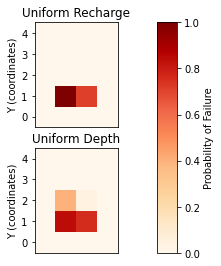

In [118]:
#TEST
#Compare to the array print out about line 30 above

fig = plt.figure('Probability of Failure0')
ax1 = fig.add_subplot(211)
ax1.xaxis.set_visible(False)
imshow_grid(grid_r, LS_prob1_r_probability_of_failure, plot_name='Uniform Recharge',
                    allow_colorbar=False, cmap='OrRd',
                    grid_units=('coordinates',''))

ax1 = fig.add_subplot(212)
ax1.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob1_d_probability_of_failure, plot_name='Uniform Depth',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates',''))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.7, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Probability of Failure', rotation=90)

## Compare the sensitivity based on four recharge options

Now lets do some plotting to see what we produced.  The four commands below will plot the probability of failure for each of the recharge options we specified above.

### Compare the Probability of failure
Now lets compare the probabilities of failure for our four recharge options.  Note - we use the arrays we named above instead of fields after 'grid'.

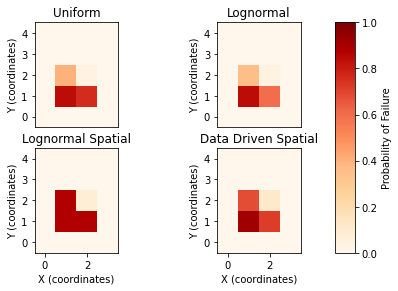

In [119]:
fig = plt.figure('Probability of Failure')
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob1_d_probability_of_failure, plot_name='Uniform',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob2_d_probability_of_failure, plot_name='Lognormal',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', ''))
ax3 = fig.add_subplot(223)
#ax3.set_xticks(xticks)
imshow_grid(grid_d, LS_prob3_d_probability_of_failure, plot_name='Lognormal Spatial',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
#ax4.set_xticks(xticks)
imshow_grid(grid_d, LS_prob4_d_probability_of_failure, plot_name='Data Driven Spatial',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.9, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Probability of Failure', rotation=90)
#plt.savefig('Probability_of_Failure_synthetic.png')

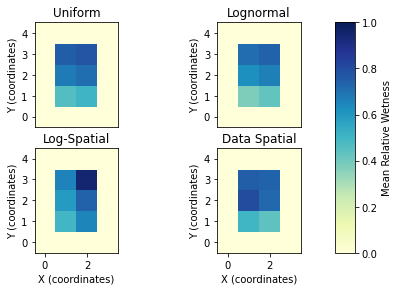

In [120]:
fig = plt.figure('Mean Relative Wetness')
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob1_d_relative_wetness, plot_name='Uniform',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob2_d_relative_wetness, plot_name='Lognormal',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', ''))
ax3 = fig.add_subplot(223)
#ax3.set_xticks(xticks)
imshow_grid(grid_d, LS_prob3_d_relative_wetness, plot_name='Log-Spatial',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
#ax4.set_xticks(xticks)
imshow_grid(grid_d, LS_prob4_d_relative_wetness, plot_name='Data Spatial',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.9, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Mean Relative Wetness', rotation=90)

#plt.savefig('Mean_Relative_Wetness_synthetic.png')

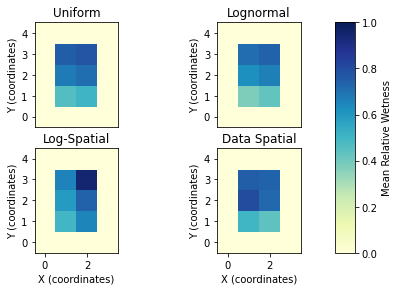

In [121]:
fig = plt.figure('Mean Relative Wetness')
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob1_d_relative_wetness, plot_name='Uniform',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob2_d_relative_wetness, plot_name='Lognormal',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', ''))
ax3 = fig.add_subplot(223)
#ax3.set_xticks(xticks)
imshow_grid(grid_d, LS_prob3_d_relative_wetness, plot_name='Log-Spatial',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
#ax4.set_xticks(xticks)
imshow_grid(grid_d, LS_prob4_d_relative_wetness, plot_name='Data Spatial',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.9, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Mean Relative Wetness', rotation=90)

#plt.savefig('Mean_Relative_Wetness_synthetic.png')

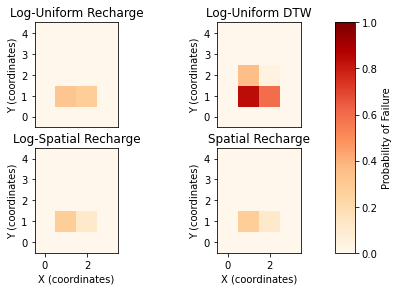

In [122]:
fig = plt.figure('Probability of Failure')
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid_r, LS_prob2_r_probability_of_failure, plot_name='Log-Uniform Recharge',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob2_d_probability_of_failure, plot_name='Log-Uniform DTW',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', ''))
ax3 = fig.add_subplot(223)
imshow_grid(grid_r, LS_prob3_r_probability_of_failure, plot_name='Log-Spatial Recharge',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
imshow_grid(grid_r, LS_prob4_r_probability_of_failure, plot_name='Spatial Recharge',
                    allow_colorbar=False, cmap='OrRd',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.9, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Probability of Failure', rotation=90)
#plt.savefig('Probability_of_Failure_synthetic.png')

Note that only the core nodes in the middle have values.  The outside nodes are closed.  Also, see how these compare with the slope plot above.

Now lets do the same for mean relative wetness.

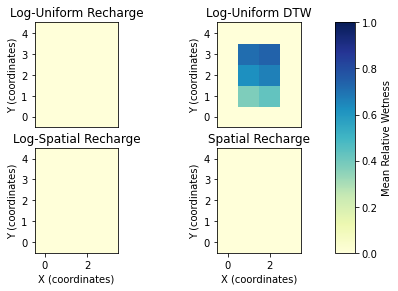

In [123]:
fig = plt.figure('Mean Relative Wetness')
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid_r, LS_prob2_r_relative_wetness, plot_name='Log-Uniform Recharge',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates',''))
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid_d, LS_prob2_d_relative_wetness, plot_name='Log-Uniform DTW',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', ''))
ax3 = fig.add_subplot(223)
#ax3.set_xticks(xticks)
imshow_grid(grid_r, LS_prob3_r_relative_wetness, plot_name='Log-Spatial Recharge',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
ax4 = fig.add_subplot(224)
#ax4.set_xticks(xticks)
imshow_grid(grid_r, LS_prob4_r_relative_wetness, plot_name='Spatial Recharge',
                    allow_colorbar=False, cmap='YlGnBu',limits=(0, 1),
                    grid_units=('coordinates', 'coordinates'))
plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.9, 0.1, 0.045, 0.8])
cbar=plt.colorbar(cax=cax)
cbar.set_label('Mean Relative Wetness', rotation=90)

#plt.savefig('Mean_Relative_Wetness_synthetic.png')

These might be all 1.0, which is the maximum, indicating that given the inputs above, this domain is often saturated.